In [1]:
from DataProcessor import Data_Processor
from DataProcessor import clean
import numpy as np


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yunzehui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yunzehui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yunzehui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yunzehui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Model Construction

### Settings

In [5]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

In [9]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [13]:
print("Dataset size:", len(df))

Dataset size: 1600000


### Merge Target Label to String

In [15]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [21]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 512 ms, sys: 31 ms, total: 543 ms
Wall time: 522 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

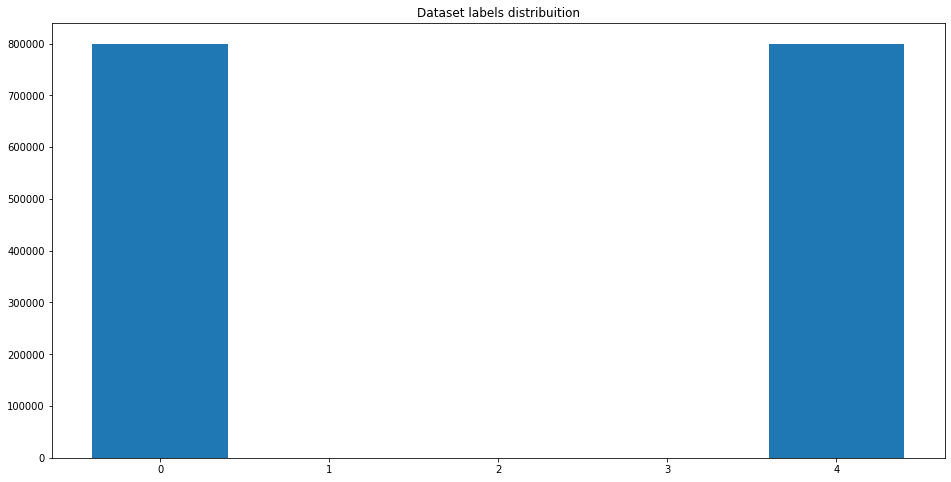

In [16]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-process Dataset

In [17]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [18]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [23]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 45.5 s, sys: 170 ms, total: 45.7 s
Wall time: 45.8 s


### Split Train and Test Set

In [28]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec

In [29]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.6 s, sys: 258 ms, total: 2.86 s
Wall time: 2.88 s


In [34]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [35]:
w2v_model.build_vocab(documents)

2020-06-16 00:27:38,073 : INFO : collecting all words and their counts
2020-06-16 00:27:38,074 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-06-16 00:27:38,100 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-06-16 00:27:38,128 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-06-16 00:27:38,147 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-06-16 00:27:38,172 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-06-16 00:27:38,195 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-06-16 00:27:38,215 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-06-16 00:27:38,242 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-06-16 00:27:38,262 : INFO : PROGRESS: at s

2020-06-16 00:27:39,580 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2020-06-16 00:27:39,603 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2020-06-16 00:27:39,624 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2020-06-16 00:27:39,645 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2020-06-16 00:27:39,666 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2020-06-16 00:27:39,687 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2020-06-16 00:27:39,708 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2020-06-16 00:27:39,730 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2020-06-16 00:27:39,754 : INFO : PROGRESS: at sentence #800000, processed 577088

In [33]:
documents

[['ya',
  'quot',
  'like',
  'palm',
  'pre',
  'touchstone',
  'charger',
  'readynow',
  'yes',
  'sounds',
  'good',
  'beer',
  'ready',
  'prelaunch'],
 ['felt', 'earthquake', 'afternoon', 'seems', 'epicenter'],
 ['ruffles', 'shirts', 'like', 'likey'],
 ['pretty',
  'bad',
  'night',
  'crappy',
  'morning',
  'fml',
  'buttface',
  'didnt',
  'say',
  'could',
  'go',
  'work',
  'today'],
 ['yeah', 'clear', 'view'],
 ['one',
  'time',
  'follow',
  'fam',
  'ff',
  'georgeann13',
  'nakithebeatman',
  'flimackgod',
  'chaz81',
  'djt',
  'elle',
  'jaejaedynomite',
  'welcome',
  'friday',
  'follow',
  '2'],
 ['u', 'rock', 'thanks', 'added', 'next', 'robcrotch', 'tm', 'video'],
 ['yes',
  'please',
  'met',
  'fiancee',
  'ian',
  'party',
  'day',
  'btw',
  'sweet',
  'congrats',
  'guys'],
 ['gawd',
  'finished',
  'whole',
  'bowl',
  'even',
  'posted',
  'previous',
  'tweet',
  'making',
  '2nd',
  'bowl'],
 ['awesome', 'game', 'short', 'finish', 'craving', 'god', 'war'

In [31]:
df_train.text.head()

1374558    ya quot like palm pre touchstone charger ready...
1389115            felt earthquake afternoon seems epicenter
1137831                            ruffles shirts like likey
790714     pretty bad night crappy morning fml buttface d...
1117911                                      yeah clear view
Name: text, dtype: object

In [36]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [37]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-06-16 00:29:15,141 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-06-16 00:29:16,167 : INFO : EPOCH 1 - PROGRESS: at 15.51% examples, 1261195 words/s, in_qsize 15, out_qsize 0
2020-06-16 00:29:17,168 : INFO : EPOCH 1 - PROGRESS: at 32.30% examples, 1320283 words/s, in_qsize 15, out_qsize 0
2020-06-16 00:29:18,174 : INFO : EPOCH 1 - PROGRESS: at 48.95% examples, 1334976 words/s, in_qsize 15, out_qsize 1
2020-06-16 00:29:19,175 : INFO : EPOCH 1 - PROGRESS: at 65.38% examples, 1339331 words/s, in_qsize 15, out_qsize 0
2020-06-16 00:29:20,178 : INFO : EPOCH 1 - PROGRESS: at 81.77% examples, 1339783 words/s, in_qsize 15, out_qsize 0
2020-06-16 00:29:21,179 : INFO : EPOCH 1 - PROGRESS: at 98.79% examples, 1349183 words/s, in_qsize 11, out_qsize 1
2020-06-16 00:29:21,203 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-16 00:29:21,211 : INFO : worker thread finished; awaiting fin

2020-06-16 00:29:51,222 : INFO : EPOCH 6 - PROGRESS: at 48.08% examples, 1308091 words/s, in_qsize 15, out_qsize 0
2020-06-16 00:29:52,232 : INFO : EPOCH 6 - PROGRESS: at 63.97% examples, 1305308 words/s, in_qsize 15, out_qsize 0
2020-06-16 00:29:53,249 : INFO : EPOCH 6 - PROGRESS: at 78.84% examples, 1284348 words/s, in_qsize 13, out_qsize 2
2020-06-16 00:29:54,255 : INFO : EPOCH 6 - PROGRESS: at 94.91% examples, 1288538 words/s, in_qsize 14, out_qsize 1
2020-06-16 00:29:54,508 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-16 00:29:54,517 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-16 00:29:54,518 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-16 00:29:54,520 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-16 00:29:54,522 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-16 00:29:54,525 : INFO : worker thread finished; awaiting finish of 2 more th

2020-06-16 00:30:27,279 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-16 00:30:27,284 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-16 00:30:27,285 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-16 00:30:27,287 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-16 00:30:27,289 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-16 00:30:27,312 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-16 00:30:27,315 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-16 00:30:27,321 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-16 00:30:27,322 : INFO : EPOCH - 11 : training on 9227204 raw words (8221890 effective words) took 7.0s, 1169634 effective words/s
2020-06-16 00:30:28,350 : INFO : EPOCH 12 - PROGRESS: at 14.65% examples, 1189687 words/s, in_qsize 12, out_qsize 3
2020-06-16 00:30:

2020-06-16 00:31:00,595 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-16 00:31:00,601 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-16 00:31:00,602 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-16 00:31:00,609 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-16 00:31:00,617 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-16 00:31:00,618 : INFO : EPOCH - 16 : training on 9227204 raw words (8223401 effective words) took 6.5s, 1265648 effective words/s
2020-06-16 00:31:01,631 : INFO : EPOCH 17 - PROGRESS: at 15.73% examples, 1288311 words/s, in_qsize 15, out_qsize 0
2020-06-16 00:31:02,648 : INFO : EPOCH 17 - PROGRESS: at 31.86% examples, 1296475 words/s, in_qsize 12, out_qsize 3
2020-06-16 00:31:03,652 : INFO : EPOCH 17 - PROGRESS: at 48.08% examples, 1307830 words/s, in_qsize 15, out_qsize 0
2020-06-16 00:31:04,658 : INFO : EPOCH 17 - PROGRESS: at 6

2020-06-16 00:31:32,196 : INFO : EPOCH - 21 : training on 9227204 raw words (8222908 effective words) took 6.2s, 1333098 effective words/s
2020-06-16 00:31:33,212 : INFO : EPOCH 22 - PROGRESS: at 16.05% examples, 1311618 words/s, in_qsize 15, out_qsize 0
2020-06-16 00:31:34,212 : INFO : EPOCH 22 - PROGRESS: at 32.19% examples, 1319437 words/s, in_qsize 15, out_qsize 0
2020-06-16 00:31:35,216 : INFO : EPOCH 22 - PROGRESS: at 48.40% examples, 1323372 words/s, in_qsize 15, out_qsize 0
2020-06-16 00:31:36,220 : INFO : EPOCH 22 - PROGRESS: at 64.62% examples, 1325294 words/s, in_qsize 16, out_qsize 3
2020-06-16 00:31:37,231 : INFO : EPOCH 22 - PROGRESS: at 81.12% examples, 1328116 words/s, in_qsize 16, out_qsize 2
2020-06-16 00:31:38,232 : INFO : EPOCH 22 - PROGRESS: at 96.75% examples, 1320286 words/s, in_qsize 15, out_qsize 0
2020-06-16 00:31:38,384 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-16 00:31:38,388 : INFO : worker thread finished; awaiting finish o

2020-06-16 00:32:08,791 : INFO : EPOCH 27 - PROGRESS: at 50.24% examples, 1024169 words/s, in_qsize 13, out_qsize 2
2020-06-16 00:32:09,795 : INFO : EPOCH 27 - PROGRESS: at 65.61% examples, 1071013 words/s, in_qsize 15, out_qsize 0
2020-06-16 00:32:10,807 : INFO : EPOCH 27 - PROGRESS: at 81.12% examples, 1102434 words/s, in_qsize 14, out_qsize 1
2020-06-16 00:32:11,812 : INFO : EPOCH 27 - PROGRESS: at 97.82% examples, 1139785 words/s, in_qsize 16, out_qsize 0
2020-06-16 00:32:11,885 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-16 00:32:11,897 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-16 00:32:11,899 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-16 00:32:11,901 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-16 00:32:11,902 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-16 00:32:11,908 : INFO : worker thread finished; awaiting finish of 2 mor

2020-06-16 00:32:43,404 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-16 00:32:43,409 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-16 00:32:43,412 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-16 00:32:43,414 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-16 00:32:43,417 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-16 00:32:43,433 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-16 00:32:43,434 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-16 00:32:43,436 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-16 00:32:43,436 : INFO : EPOCH - 32 : training on 9227204 raw words (8222480 effective words) took 6.5s, 1257658 effective words/s
2020-06-16 00:32:43,437 : INFO : training on a 295270528 raw words (263124140 effective words) took 208.3s, 1263244 effective words/s

CPU times: user 14min 30s, sys: 5.37 s, total: 14min 36s
Wall time: 3min 28s


(263124140, 295270528)

In [38]:
w2v_model.most_similar("love")

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-06-16 00:34:33,536 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5767787098884583),
 ('loves', 0.5516685247421265),
 ('loved', 0.5384792685508728),
 ('adore', 0.528795063495636),
 ('amazing', 0.5107707977294922),
 ('looove', 0.5066909790039062),
 ('loveee', 0.4771583080291748),
 ('awesome', 0.4635373055934906),
 ('lovee', 0.4529687166213989),
 ('loooove', 0.4352604150772095)]

### Tokenize Text

In [39]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 15.5 s, sys: 351 ms, total: 15.9 s
Wall time: 15.9 s


In [43]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 22.9 s, sys: 3.38 s, total: 26.2 s
Wall time: 26.9 s


In [44]:
x_train

array([[     0,      0,      0, ...,    712,    118,  24590],
       [     0,      0,      0, ...,    452,    378,  32447],
       [     0,      0,      0, ...,   2048,      4,   5487],
       ...,
       [     0,      0,      0, ...,    661,   4246, 290416],
       [     0,      0,      0, ...,     12,    477,    957],
       [     0,      0,      0, ...,      9,    502,    268]], dtype=int32)

### Label Encoder

In [45]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [46]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [47]:
y_train

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [48]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


### Embedding Layer

In [49]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [50]:
embedding_matrix
#每一个词转化为一个300长的向量
#matrix显示目前训练好的w2v_model词库中290419个词的vector

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.11830675, -0.65860373, -0.09315446, ..., -0.75426108,
         0.15312332,  0.49520558],
       [-0.41199678,  2.35673761, -0.17127493, ..., -1.81825912,
        -1.47179914, -0.24724415],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [54]:
w2v_model.wv.vocab

{'ya': <gensim.models.keyedvectors.Vocab at 0x1a53f864e0>,
 'quot': <gensim.models.keyedvectors.Vocab at 0x1aaff0cf28>,
 'like': <gensim.models.keyedvectors.Vocab at 0x1aaff0ce80>,
 'palm': <gensim.models.keyedvectors.Vocab at 0x1aaff0ce10>,
 'pre': <gensim.models.keyedvectors.Vocab at 0x1aaff0cb70>,
 'charger': <gensim.models.keyedvectors.Vocab at 0x1aaff0cc18>,
 'yes': <gensim.models.keyedvectors.Vocab at 0x1aaff0cb38>,
 'sounds': <gensim.models.keyedvectors.Vocab at 0x1aaff0cb00>,
 'good': <gensim.models.keyedvectors.Vocab at 0x1aaff0cac8>,
 'beer': <gensim.models.keyedvectors.Vocab at 0x1aaff0ca90>,
 'ready': <gensim.models.keyedvectors.Vocab at 0x1aaff0ca58>,
 'prelaunch': <gensim.models.keyedvectors.Vocab at 0x1aaff0ca20>,
 'felt': <gensim.models.keyedvectors.Vocab at 0x1aaff0c9e8>,
 'earthquake': <gensim.models.keyedvectors.Vocab at 0x1aaff0c9b0>,
 'afternoon': <gensim.models.keyedvectors.Vocab at 0x1aaff0c978>,
 'seems': <gensim.models.keyedvectors.Vocab at 0x1aaff0c940>,
 'shi

In [51]:
w2v_model.wv.vocab.keys()

dict_keys(['ya', 'quot', 'like', 'palm', 'pre', 'charger', 'yes', 'sounds', 'good', 'beer', 'ready', 'prelaunch', 'felt', 'earthquake', 'afternoon', 'seems', 'shirts', 'likey', 'pretty', 'bad', 'night', 'crappy', 'morning', 'fml', 'didnt', 'say', 'could', 'go', 'work', 'today', 'yeah', 'clear', 'view', 'one', 'time', 'follow', 'fam', 'ff', 'elle', 'welcome', 'friday', '2', 'u', 'rock', 'thanks', 'added', 'next', 'tm', 'video', 'please', 'met', 'fiancee', 'ian', 'party', 'day', 'btw', 'sweet', 'congrats', 'guys', 'gawd', 'finished', 'whole', 'bowl', 'even', 'posted', 'previous', 'tweet', 'making', '2nd', 'awesome', 'game', 'short', 'finish', 'craving', 'god', 'war', 'action', 'happy', 'mothers', 'grown', 'n', 'amp', 'lil', 'prego', 'lol', 'playing', 'everyone', 'loved', 'bless', 'back', 'eating', 'dinner', 'chat', 'room', 'many', 'heck', 'way', 'heights', 'want', 'trade', 'tired', 'saying', 'goodbye', 'chicago', 'stole', 'half', '12', 'mai', 'tai', 'inbound', 'suddenly', 'trouble', 'rel

In [57]:
w2v_model.wv['ya']

array([-0.03469687,  0.27157623, -0.89536667, -1.55363   ,  0.05955459,
       -0.06336015, -1.1069763 , -0.84753233,  0.2969354 ,  0.90005076,
       -0.82901883, -0.37726063, -0.8885095 ,  0.77874804, -0.01403165,
        0.6401563 ,  1.3687544 , -0.04153271,  1.208283  , -0.7818452 ,
        0.9706931 ,  0.0826459 , -0.2730759 ,  0.6554017 ,  0.20393951,
       -0.43390736, -0.98072875,  0.4614257 ,  0.06025992,  1.2023255 ,
       -1.0886767 ,  1.3064735 ,  1.4559228 , -0.2925316 , -1.182235  ,
        1.4150494 , -0.44252065, -1.8643864 ,  1.0639595 ,  0.07231372,
       -0.11818169, -0.8769076 , -0.78438807, -0.42491275, -0.35768485,
       -0.45254207,  0.9924106 , -0.5722048 , -0.54435295,  0.38966185,
        0.07675732, -0.6446221 ,  0.74493426,  0.32090655,  1.0694752 ,
        0.02980385, -1.3684303 ,  0.5237204 , -1.1538801 ,  0.62020224,
        1.0062544 ,  1.064217  , -0.2730605 ,  1.7504033 , -0.08210488,
        0.42874327,  0.8066127 ,  0.11934638, -0.14724384,  1.18

In [58]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [59]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [60]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
#这里是二分类

### Callbacks

In [61]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [63]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 3669s 3ms/step - loss: 0.5067 - accuracy: 0.7485 - val_loss: 0.4660 - val_accuracy: 0.7789
Epoch 2/8


//anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1152000/1152000 [==============================] - 3620s 3ms/step - loss: 0.4830 - accuracy: 0.7645 - val_loss: 0.4569 - val_accuracy: 0.7838
Epoch 3/8
1152000/1152000 [==============================] - 3631s 3ms/step - loss: 0.4760 - accuracy: 0.7690 - val_loss: 0.4533 - val_accuracy: 0.7859
Epoch 4/8
1152000/1152000 [==============================] - 3580s 3ms/step - loss: 0.4722 - accuracy: 0.7715 - val_loss: 0.4513 - val_accuracy: 0.7877
Epoch 5/8
1152000/1152000 [==============================] - 3550s 3ms/step - loss: 0.4699 - accuracy: 0.7729 - val_loss: 0.4488 - val_accuracy: 0.7888
Epoch 6/8
1152000/1152000 [==============================] - 3573s 3ms/step - loss: 0.4679 - accuracy: 0.7743 - val_loss: 0.4491 - val_accuracy: 0.7892
Epoch 7/8
1152000/1152000 [==============================] - 3569s 3ms/step - loss: 0.4661 - accuracy: 0.7755 - val_loss: 0.4468 - val_accuracy: 0.7896
Epoch 8/8
1152000/1152000 [==============================] - 3660s 3ms/step - loss: 0.4650 - accur

### Evaluate

In [64]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 366s 1ms/step

ACCURACY: 0.791015625
LOSS: 0.44398590331077575
CPU times: user 21min 44s, sys: 10min 14s, total: 31min 58s
Wall time: 6min 5s


In [67]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])

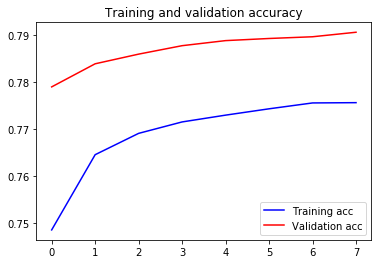

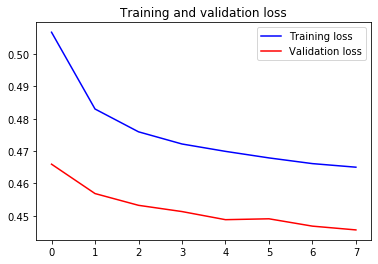

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [69]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [70]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [71]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9720866084098816,
 'elapsed_time': 0.22046518325805664}

### Confusion Matrix

In [72]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

320000/320000 [==============================] - 476s 1ms/step
CPU times: user 21min 10s, sys: 13min 47s, total: 34min 57s
Wall time: 7min 56s


In [73]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

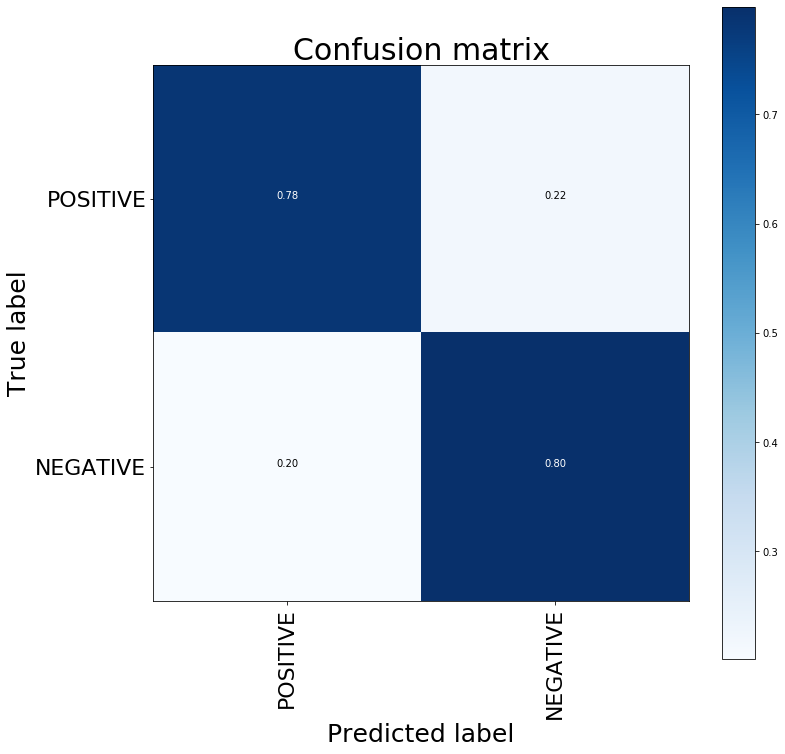

CPU times: user 3.22 s, sys: 174 ms, total: 3.39 s
Wall time: 1.23 s


In [74]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [75]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.78      0.79    159494
    POSITIVE       0.79      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



### Accuracy Score

In [76]:
accuracy_score(y_test_1d, y_pred_1d)

0.791015625

### Save Model

In [77]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-06-16 09:52:02,204 : INFO : saving Word2Vec object under model.w2v, separately None
2020-06-16 09:52:02,213 : INFO : not storing attribute vectors_norm
2020-06-16 09:52:02,214 : INFO : not storing attribute cum_table
2020-06-16 09:52:03,305 : INFO : saved model.w2v


## Test on Sentiment140 test set

In [135]:
dftest = pd.read_csv("testdata.manual.2009.06.14.csv", encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [137]:
print("Dataset size:", len(dftest))

Dataset size: 498


In [138]:
%%time
dftest.target = dftest.target.apply(lambda x: decode_sentiment(x))

CPU times: user 2.06 ms, sys: 7.74 ms, total: 9.8 ms
Wall time: 20 ms


Text(0.5, 1.0, 'Test dataset labels distribuition')

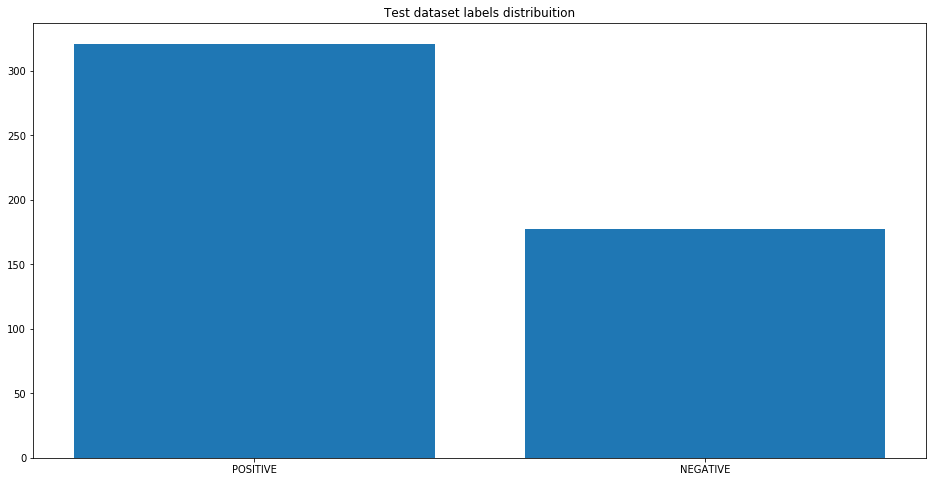

In [139]:
testtarget_cnt = Counter(dftest.target)

plt.figure(figsize=(16,8))
plt.bar(testtarget_cnt.keys(), testtarget_cnt.values())
plt.title("Test dataset labels distribuition")

In [142]:
x_test2 = pad_sequences(tokenizer.texts_to_sequences(dftest.text), maxlen=SEQUENCE_LENGTH)

In [143]:
x_test2

array([[    0,     0,     0, ...,    24,   890,    48],
       [    0,     0,     0, ..., 26667,     1,   224],
       [    0,     0,     0, ..., 70717,   508,  1223],
       ...,
       [    0,     0,     0, ...,    78,    41, 17439],
       [    0,     0,     0, ...,  1915,   253,   135],
       [    0,     0,     0, ...,  9167,  2813,    44]], dtype=int32)

In [145]:
y_test2 = encoder.transform(dftest.target.tolist())
y_test2 = y_test2.reshape(-1,1)
print("x_test2", x_test2.shape)
print("y_test2", y_test2.shape)

x_test2 (498, 300)
y_test2 (498, 1)


In [146]:
%%time
score2 = model.evaluate(x_test2, y_test2, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

498/498 [==============================] - 1s 1ms/step

ACCURACY: 0.791015625
LOSS: 0.44398590331077575
CPU times: user 1.76 s, sys: 1.04 s, total: 2.8 s
Wall time: 719 ms


In [147]:
%%time
y_pred_1d2 = []
y_test_1d2 = list(dftest.target)
scores = model.predict(x_test2, verbose=1, batch_size=8000)
y_pred_1d2 = [decode_sentiment(score, include_neutral=False) for score in scores]

498/498 [==============================] - 1s 1ms/step
CPU times: user 1.73 s, sys: 996 ms, total: 2.73 s
Wall time: 681 ms


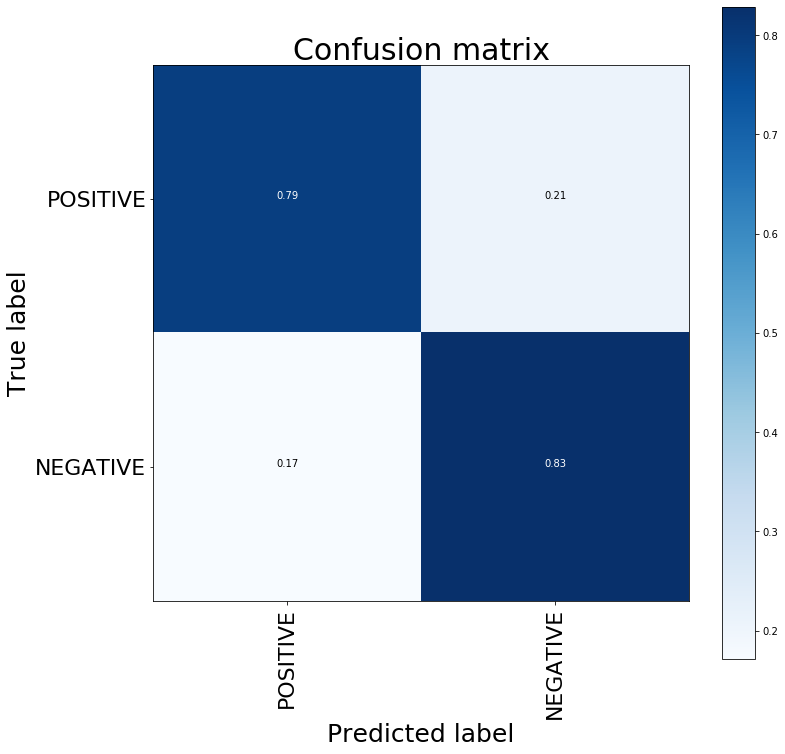

CPU times: user 844 ms, sys: 67 ms, total: 911 ms
Wall time: 341 ms


In [150]:
%%time

cnf_matrix2 = confusion_matrix(y_test_1d2, y_pred_1d2)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix2, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [151]:
print(classification_report(y_test_1d2, y_pred_1d2))

              precision    recall  f1-score   support

    NEGATIVE       0.72      0.79      0.75       177
    POSITIVE       0.88      0.83      0.85       321

    accuracy                           0.82       498
   macro avg       0.80      0.81      0.80       498
weighted avg       0.82      0.82      0.82       498



In [152]:
accuracy_score(y_test_1d2, y_pred_1d2)

0.8152610441767069

# Use Trained Model to Predict the Sentiment of Our Tweets

In [78]:
DP=Data_Processor(start_month='2019-01',end_month='2020-02',template="Data/Wealth_Management")
DP.readdata()
DP.specifylang()
DP.clean()

In [79]:
def preprocess(text_list, stem=False):
    # Remove stopwords, set lowercase, link tokens
    tokens = []
    for string in text_list:
        token = DP.getngrams(data=string,num=1,lemma=True)
        m = " ".join(str(v) for v in token)
        tokens.append(m)
    return tokens

In [80]:
text_list_processed = preprocess(DP.textdata()[0]) #analyze the text of first month(2019-01)

In [118]:
text_list_processed

['hey swissborg like article coindesk simple fair ecosystem powered technology',
 'global insight survey finding highnetworth individual worldwide expect future relationship managed primarily entirely online luxedigitalmag',
 'digital evolution wealth management emerging technology improve user experience cutting cost boosting revenue biuk',
 'rise roboadvisers uae lowcost platform targeting younger professional easier resident save thenationaluae',
 'never get second chance brand',
 'simple trick could secret warren buffetts success',
 'ironwood group player game go grace pyatt',
 'ceo david root featured prominently pittsburgh post gazette article morning inorganic growth acquisition firm read perspective',
 'aphria tsxapha stock mostwatched cannabis investment right',
 'k access allby law putnams reynolds kspecmag',
 'seems quovo compliment plaid fintech solution well bravo excellent acquisition growth win plaid',
 'hey swissborg like article coindesk simple fair ecosystem powered t

In [84]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE
    
def predict_self(text_list_processed, include_neutral=True):
    start_at = time.time()
    result = pd.DataFrame(columns=['text', 'label', 'score', 'elapsed_time'])
    for text in text_list_processed:
        # Tokenize text
        x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
        # Predict
        score = model.predict([x_test])[0]
        # Decode sentiment
        label = decode_sentiment(score, include_neutral=include_neutral)
        elapsed_time = time.time()-start_at
        result = result.append(pd.DataFrame({'text':[text],'label':[label],'score':[float(score)],'elapsed_time':[elapsed_time]}),ignore_index=True)
    return result  

In [122]:
%%time

result = predict_self(text_list_processed)

CPU times: user 6min 33s, sys: 1min 18s, total: 7min 51s
Wall time: 3min 25s


In [133]:
print(result)

                                                    text     label     score  \
0      hey swissborg like article coindesk simple fai...  POSITIVE  0.780159   
1      global insight survey finding highnetworth ind...  POSITIVE  0.900442   
2      digital evolution wealth management emerging t...   NEUTRAL  0.520578   
3      rise roboadvisers uae lowcost platform targeti...  POSITIVE  0.872826   
4                          never get second chance brand   NEUTRAL  0.400478   
5      simple trick could secret warren buffetts success  POSITIVE  0.935805   
6              ironwood group player game go grace pyatt  POSITIVE  0.910653   
7      ceo david root featured prominently pittsburgh...  POSITIVE  0.969687   
8      aphria tsxapha stock mostwatched cannabis inve...   NEUTRAL  0.635976   
9           k access allby law putnams reynolds kspecmag   NEUTRAL  0.621294   
10     seems quovo compliment plaid fintech solution ...  POSITIVE  0.810736   
11     hey swissborg like article coinde